## LSTM 예측

### 055550.KS

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# 데이터 로드
stock_data = pd.read_csv('055550.KS.csv')
original_close = stock_data['Close'].values
dates = pd.to_datetime(stock_data['Date'])

# 필요한 컬럼만 선택
stock_data = stock_data[["Close"]]

In [3]:
# 데이터 스케일링
scaler = StandardScaler()
stock_data_scaled = scaler.fit_transform(stock_data)

n_train = int(0.8*len(stock_data_scaled))
train_data_scaled = stock_data_scaled[:n_train]
train_dates = dates[:n_train]

C:\Users\cho03\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cho03\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cho03\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cho03\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

In [4]:
seq_len = 100  # sequence length 
trainX, trainY = [], []
n_future = 15

for i in range(seq_len, len(train_data_scaled)-n_future):  
    trainX.append(train_data_scaled[i-seq_len:i])
    trainY.append(train_data_scaled[i:i+n_future, 0])  

trainX, trainY = np.array(trainX), np.array(trainY)

In [5]:
# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(25, return_sequences=False))
model.add(Dense(n_future))  # 수정된 부분

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           30200     
                                                                 
 lstm_2 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 15)                390       
                                                                 
Total params: 78990 (308.55 KB)
Trainable params: 78990 (308.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# 학습률 설정
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# EarlyStopping과 ModelCheckpoint 설정
es = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('./save_weights/055550.KS_lstm_best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

모델을 찾을 수 없습니다, 모델을 처음부터 학습합니다.
Epoch 1/100

132/132 [==============================] - 44s 237ms/step - loss: 0.2046 - val_loss: 0.0308
Epoch 2/100


C:\Users\cho03\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 27s 207ms/step - loss: 0.0357 - val_loss: 0.0215
Epoch 3/100
132/132 [==============================] - 28s 209ms/step - loss: 0.0331 - val_loss: 0.0205
Epoch 4/100
132/132 [==============================] - 28s 213ms/step - loss: 0.0320 - val_loss: 0.0192
Epoch 5/100
132/132 [==============================] - 29s 220ms/step - loss: 0.0302 - val_loss: 0.0268
Epoch 6/100
132/132 [==============================] - 27s 206ms/step - loss: 0.0302 - val_loss: 0.0199
Epoch 7/100
132/132 [==============================] - 31s 238ms/step - loss: 0.0287 - val_loss: 0.0186
Epoch 8/100
132/132 [==============================] - 25s 186ms/step - loss: 0.0285 - val_loss: 0.0217
Epoch 9/100
132/132 [==============================] - 26s 198ms/step - loss: 0.0276 - val_loss: 0.0170
Epoch 10/100
132/132 [==============================] - 26s 196ms/step - loss: 0.0268 - val_loss: 0.0178
Epoch 11/100
132/132 [==============================] - 25s 193ms/step - lo

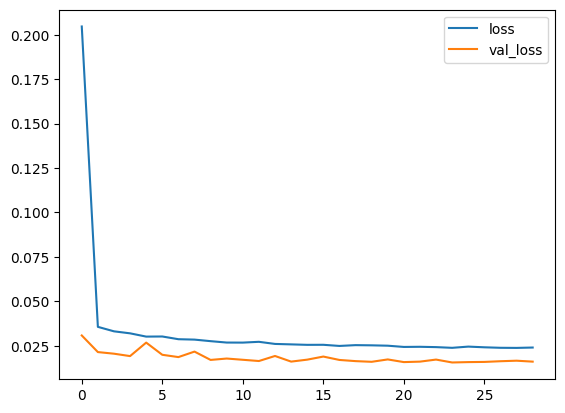

In [7]:
# 모델 불러오기 혹은 학습
try:
    model = load_model('./save_weights/055550.KS_lstm_best_model.h5')
    print("디스크에서 모델을 불러왔습니다.")
except:
    print("모델을 찾을 수 없습니다, 모델을 처음부터 학습합니다.")
    history = model.fit(trainX, trainY, epochs=100, batch_size=32,
                    validation_split=0.1, verbose=1, callbacks=[es, mc])

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [8]:
# 가장 최근 100일의 데이터로 30일 후 종가 예측
recent_data_scaled = stock_data_scaled[-seq_len:]
recent_data_scaled = np.expand_dims(recent_data_scaled, 0)
predicted_prices_scaled = model.predict(recent_data_scaled)

1/1 [==============================] - 7s 7s/step


In [9]:
# 예측 결과를 원래 스케일로 변환
predicted_prices = scaler.inverse_transform(predicted_prices_scaled)
predicted_prices = predicted_prices.flatten()  # 2D array to 1D array

print(predicted_prices)

[38694.938 38694.715 38697.453 38703.555 38850.92  38690.977 38985.547
 39028.145 38855.684 38940.973 38844.2   38827.05  39055.043 39026.254
 39051.81 ]


In [31]:
dates[-15:]

5994   2023-11-27
5995   2023-11-28
5996   2023-11-29
5997   2023-11-30
5998   2023-12-01
5999   2023-12-04
6000   2023-12-05
6001   2023-12-06
6002   2023-12-07
6003   2023-12-08
6004   2023-12-11
6005   2023-12-12
6006   2023-12-13
6007   2023-12-14
6008   2023-12-15
Name: Date, dtype: datetime64[ns]

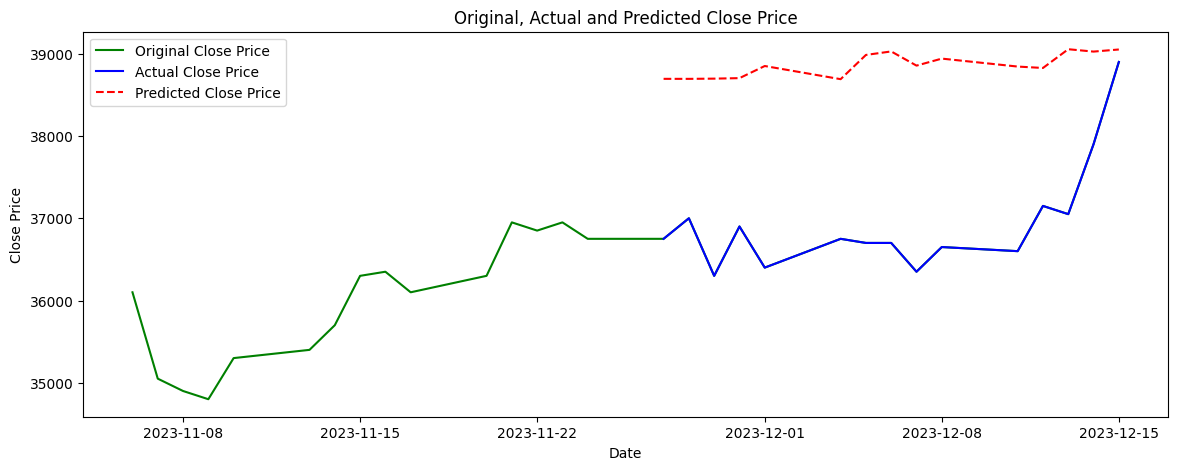

In [36]:
# plotting
plt.figure(figsize=(14, 5))

# plot original 'Close' prices
plt.plot(dates[-30:], original_close[-30:], color='green', label='Original Close Price')

# plot actual vs predicted
plt.plot(dates[-15:], original_close[-15:], color='blue', label='Actual Close Price')
plt.plot(dates[-15:], predicted_prices, color='red', linestyle='--', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Original, Actual and Predicted Close Price')
plt.legend()
plt.show()

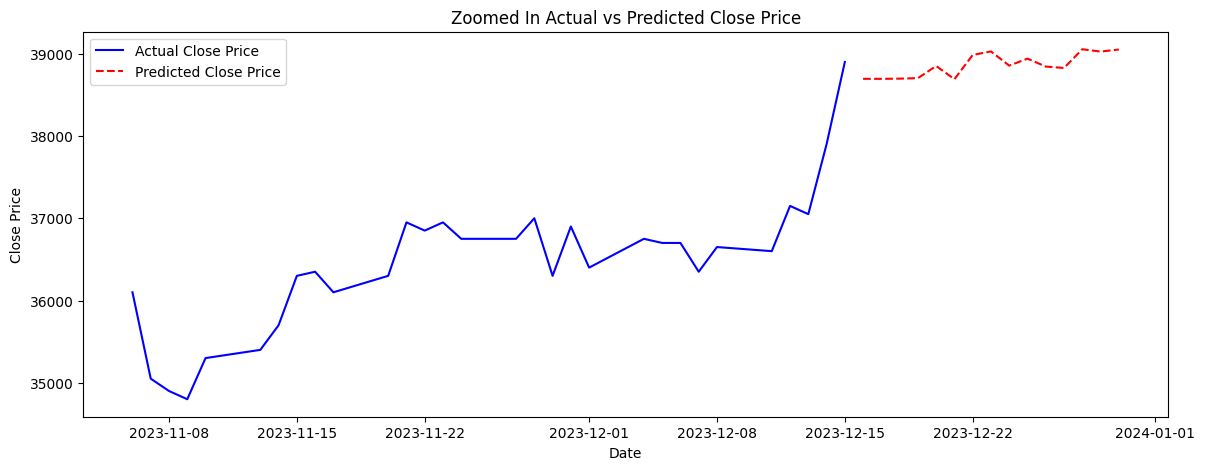

In [25]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(dates) - 30
zoom_end = len(dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# 실제 종가 데이터를 표시
plt.plot(dates[zoom_start:],
         original_close[zoom_start:],
         color='blue',
         label='Actual Close Price')

# 예측 종가 데이터를 표시
start_date = dates.iloc[-1] + pd.DateOffset(1)
end_date = start_date + pd.DateOffset(14)
predicted_dates = pd.date_range(start_date, end_date)

plt.plot(predicted_dates,
         predicted_prices,
         color='red',
         linestyle='--',
         label='Predicted Close Price')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Zoomed In Actual vs Predicted Close Price')
plt.legend()

In [ ]:
# 가장 최근 30일의 실제 가격
recent_original_prices = original_close[-15:]

# MSE, MAE 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(recent_original_prices, predicted_prices)
mae = mean_absolute_error(recent_original_prices, predicted_prices)
print(f"모델의 예측 결과 평가: MSE = {mse:.2f}, MAE = {mae:.2f}")

In [ ]:
# 가장 최근 100일의 데이터로 30일 후 종가 예측
recent_data_scaled = stock_data_scaled[-100:]
recent_data_scaled = np.expand_dims(recent_data_scaled, 0)
predicted_prices_scaled = model.predict(recent_data_scaled)

# 예측 결과를 원래 스케일로 변환
predicted_prices = scaler.inverse_transform(predicted_prices_scaled)
predicted_prices = predicted_prices.flatten()  # 2D array to 1D array

print(predicted_prices)

In [ ]:
plt.plot(predicted_prices)